#**Deep Learning Homework 5: *Autoencoders***
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [1]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 3s 0us/step


## Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of their intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [3]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [4]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [7]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

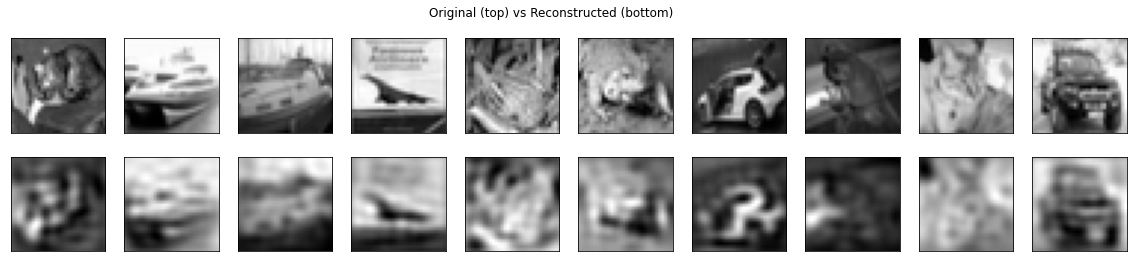

In [8]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

What happens by varying the `ENCODING_DIM`?

As one would expect, increasing ENCODING_DIM leads to better reconstruction of the original dataset. To understand why this happens let's have a look at the general theory behind SVD decomposition.\
Let $A \in \mathbb{R}^{m\times n}$ with $m\geq n $, since every matrix admits SVD we know there exist: $U \in \mathbb{R}^{m\times m}, V \in \mathbb{R}^{n\times n}$ unitary and $S \in \mathbb{R}^{m\times n}$ pseudo-diagonal such that: $A=USV^{T}$.\
In particular
\begin{equation}
S_{ij}=
\begin{cases} 
      \sigma_{i} \qquad for \;\; i=j\\
      0 \qquad otherwise
\end{cases}
\qquad for \quad i \in \{1, ..., m\}, \quad j \in \{1, ..., n\}
\end{equation}
with $\{\sigma_{i}\}_{i=1, ..., n}$ singular values satisfying
\begin{equation}
\sigma_{1} \geq \sigma_{2} \geq ... \geq \sigma_{n} \geq 0.
\end{equation}
Let's now suppose A of rank $r$, then since $U$ and $V$ are invertible it's easy to see that $r := rank(A) = |\{\sigma_{i} \;|\; \sigma_{i}\neq0, \;\; i=1, ..., n\}|$.\
At this point, from linear algebra courses we know that a best $k-rank$ approximation of $A$ for the Frobenius norm can be obtained truncating the SVD. More precisely: $A_{k} = U_kS_kV_k^{T}$ with
* $U_k = U[:, :k]$
* $S_k = S[:k, :k]$
* $V_k = V[:, :k]$

is a best $k-rank$ approximation of $A$, meaning that it's a solution of the following minimization problem
\begin{equation}
\min_{B \in \mathbb{R}^{m\times n},\; rank(B)=k} || A - B ||_{F}
\end{equation}
and moreover
\begin{equation}
||A-A_{k}||_{F} = \sqrt{\sum_{i=k+1}^{r}{\sigma_{i}^2}}.
\end{equation}
In our case ENCODING_DIM plays the same role as parameter $k$ and x_training_reco corresponds exactly the matrix $A_k$. It follows that the greater ENCODING_DIM, the smaller the norm of the difference, i.e. the better the reconstruction.\
Nonenthless, since $\sigma_{1} \geq \sigma_{2} \geq ... \geq \sigma_{n} \geq 0$ it follows that in general even for small numbers of $k$ the approximation is still quite good.

## Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [9]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 4s 38ms/step - loss: 0.1766 - val_loss: 0.0311
Epoch 2/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0285 - val_loss: 0.0211
Epoch 3/15
79/79 [==============================] - 3s 36ms/step - loss: 0.0215 - val_loss: 0.0167
Epoch 4/15
79/79 [==============================] - 3s 36ms/step - loss: 0.0167 - val_loss: 0.0136
Epoch 5/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0125 - val_loss: 0.0118
Epoch 6/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 7/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 8/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 9/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 10/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0053 - 788ms/epoch - 3ms/step
Test mse: 0.00534


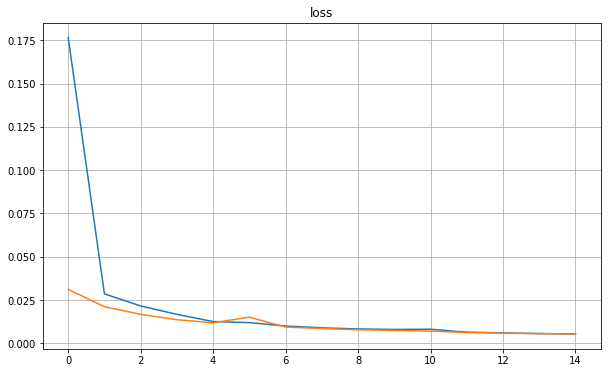

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

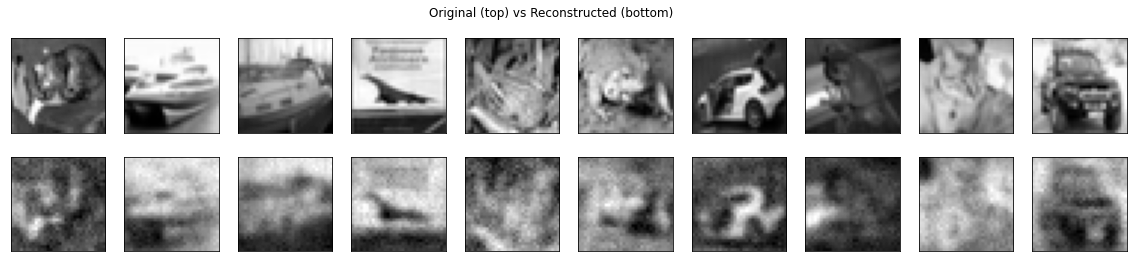

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Let's now compare such results with the ones obtained using SVD. Is there any relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition?


_Answer:_ as we expected SVD performed better than the linear shallow autoencoder, achieving better reconstructions.\
We notice though that a linear shallow autoencoder with MSE as loss function is very similar to SVD, since they both try to minimize the same reconstruction error.\
In fact, let's assume $f(⋅)$ and $g(⋅)$ to be the encoding and decoding function respectively, and let's use the MSE as Loss function, then what the autoencoder is trying to do is to determine $f(⋅)$ and $g(⋅)$ so to minimize $||X-g(f(X))||_{F}$.\
If now $f(⋅)$ and $g(⋅)$ are linear functions, then $g(f(X))=BAX$ with $A, \;B$ matrices of proper dimensions, and what we obtain is the same reconstruction error SVD also tries to minimize.\
In fact, as we said above the truncated SVD provides a best low rank approximation (w.r.t. $||⋅||_{F}$ and also $||⋅||_{2}$) for every given matrix.\
The thing though is that while SVD provides an exact closed form solution, the autoencoder tries to infer such solution via iterative optimization algorithms, so the final result is likely to be less accurate, as we noticed.

## Exercise 5.3: Shallow Non-linear Autoencoders

Let's now replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions we use non-linear ones.


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 dense_7 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0356 - val_loss: 0.0274
Epoch 2/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0211 - val_loss: 0.0179
Epoch 3/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 4/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0138 - val_loss: 0.0126
Epoch 5/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0123 - val_loss: 0.0110
Epoch 6/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0127 - val_loss: 0.0106
Epoch 7/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0099 - val_loss: 0.0106
Epoch 8/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 9/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 10/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0068 - 842ms/epoch - 3ms/step
Test mse: 0.00683


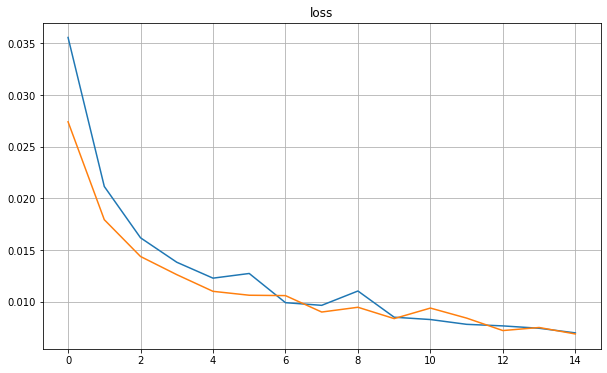

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

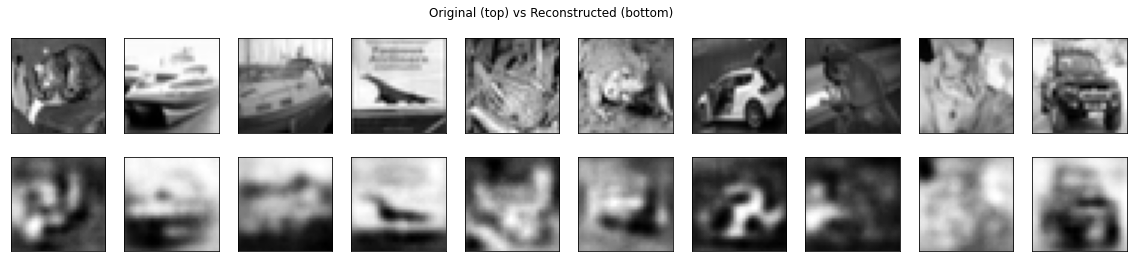

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

After testing various activation functions, we found out that using sigmoid on both layers yielded the best reconstructions for the test set.\
We also tried several others activations, such as: selu, elu, softsign, exp, tanh, but none of these was able to perform as good as the sigmoid.\
Interestingly, using tanh both for the encoder and the decoder provided a reconstruction with some white dots in a fixed position, for each one of the images we plotted.\
We conclude by saying that since all the entries of X are normalized between $0$ and $1$, it actually makes sense to use the sigmoid as decoding function, since it spits out values in the appropriate range, i.e. $(0,1)$.

## Exercise 5.4: Deep Autoencoder
We now build a deep version of the Autoencoder defined above.
The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, we print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 256
n=3

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = input_img
k = (INPUT_DIM-ENCODING_DIM)/n
encoded = tf.keras.layers.Dense(np.floor(INPUT_DIM-k*(0+1)), activation='sigmoid')(encoded)

# Define the encoder...
for i in range(1, n):
  size = np.floor(INPUT_DIM-k*(i+1))
  encoded = tf.keras.layers.Dense(size, activation='tanh')(encoded)

# define the decoder...
decoded = encoded
for i in range(n-1):  
  size = np.floor(ENCODING_DIM+k*(i+1))
  decoded = tf.keras.layers.Dense(size, activation='tanh')(decoded)

decoded = tf.keras.layers.Dense(np.floor(ENCODING_DIM+k*n), activation='sigmoid')(decoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_8 (Dense)             (None, 768)               787200    
                                                                 
 dense_9 (Dense)             (None, 512)               393728    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dense_12 (Dense)            (None, 768)               393984    
                                                                 
 dense_13 (Dense)            (None, 1024)              787

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 5, batch_size= 32, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/5
1250/1250 [==============================] - 52s 41ms/step - loss: 0.0136 - val_loss: 0.0087
Epoch 2/5
1250/1250 [==============================] - 50s 40ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 3/5
1250/1250 [==============================] - 51s 41ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 4/5
1250/1250 [==============================] - 50s 40ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 5/5
1250/1250 [==============================] - 50s 40ms/step - loss: 0.0049 - val_loss: 0.0047


313/313 - 2s - loss: 0.0047 - 2s/epoch - 8ms/step
test mse: 0.00469


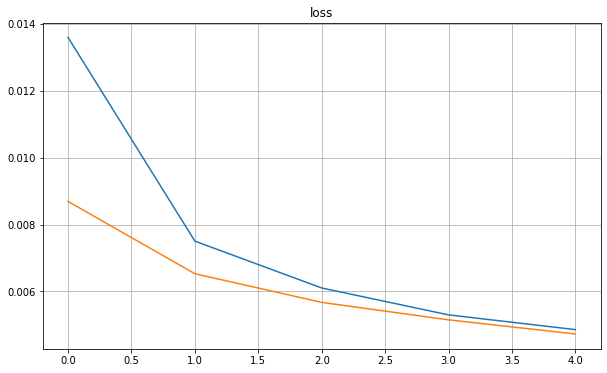

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

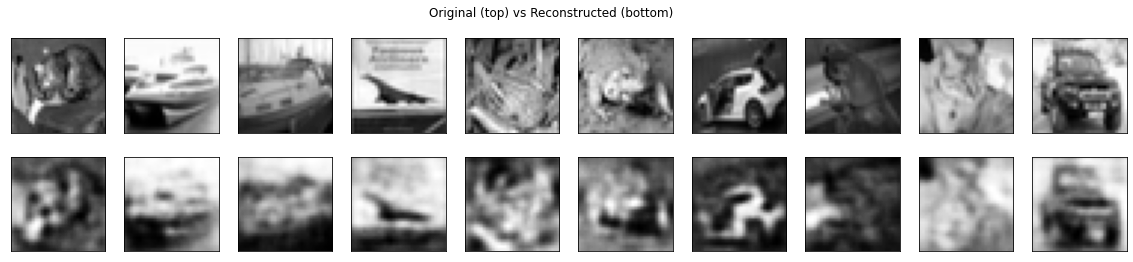

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

From the various tests we performed, turned out that going deeper actually deteriorates the performances of the model if we keep the same learning rate and batch size as before.\
We tried several combinations of activation functions but none of these models was able to perform as good as the non-linear shallow autoencoder of the previous exercise.\
What we found out though, is that varying batch size and learning rate greatly affects the final reconstructions, as one could expect.\
Specifically, decreasing the learning rate down to 0.0005 ant the batch size down to 32 provided pretty good results, comparable to the ones achieved by the linear shallow autoencoder.

## Deep Convolutional Autoencoder

Since we're dealing with images, let's also have a look at a simple deep convolutional autoencoder, keeping the same activation functions as well as batch size and learning rate we used before.\
We'll try to keep the hourglass structure as well.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [ ]:
ENCODING_DIM = 256
n=4

# reshape the vectors to get back the image structure
x_train_conv = x_train.reshape(x_train.shape[0],32,32)
x_valid_conv = x_valid.reshape(x_valid.shape[0],32,32)
x_test_conv = x_test.reshape(x_test.shape[0],32,32)

input = layers.Input(shape=(32, 32, 1))

encoded  = layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(32, 32, 1), padding='same')(input)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)

# Define the encoder...
for i in range(n-1):
  encoded = layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(encoded)
  encoded = layers.MaxPooling2D((2, 2))(encoded)

# get dimension of the current image, we'll need this to give the network an hourglass structure
dim1 = encoded.shape[1:]
# flatten the image
encoded = layers.Flatten()(encoded)
# get dimension of the flattened image, we'll need this to give the network an hourglass structure
dim2 = encoded.shape[1]
# final encoding
encoded = layers.Dense(ENCODING_DIM, activation='sigmoid')(encoded)

# now let's build up the decoder
decoded = layers.Dense(dim2, activation='tanh')(encoded)
decoded = layers.Reshape(dim1)(decoded)

for i in range(n):  
  decoded = layers.Conv2DTranspose(32, (2, 2), strides=2, activation="tanh", padding="valid")(decoded)
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", strides=1, padding="same")(decoded)

# and the autoencoder
autoencoder = Model(input, decoded)

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          924

In [ ]:
history = autoencoder.fit(x_train_conv, x_train_conv, epochs= 5, batch_size= 32, shuffle=True, validation_data=(x_valid_conv, x_valid_conv))

Epoch 1/5
1250/1250 [==============================] - 143s 114ms/step - loss: 0.0225 - val_loss: 0.0146
Epoch 2/5
1250/1250 [==============================] - 141s 113ms/step - loss: 0.0132 - val_loss: 0.0121
Epoch 3/5
1250/1250 [==============================] - 140s 112ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 4/5
1250/1250 [==============================] - 139s 112ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 5/5
1250/1250 [==============================] - 139s 111ms/step - loss: 0.0101 - val_loss: 0.0100


313/313 - 7s - loss: 0.0099 - 7s/epoch - 23ms/step
test mse: 0.00993


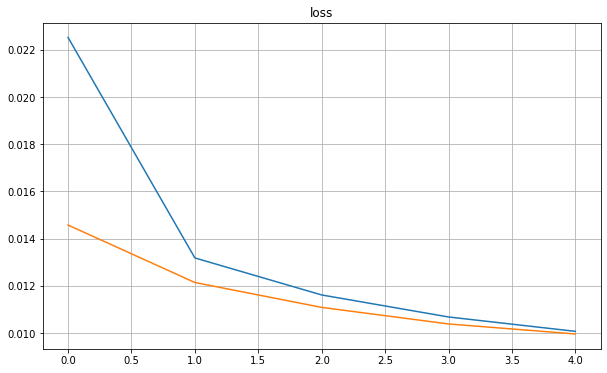

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_conv, x_test_conv, verbose=2)
print("test mse: %.5f" % (scores))

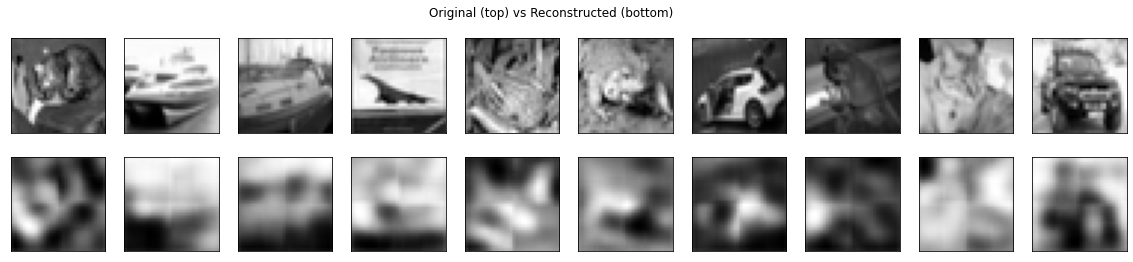

In [ ]:
decoded_imgs = autoencoder.predict(x_test_conv)

plot_img(10, [x_test_conv, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

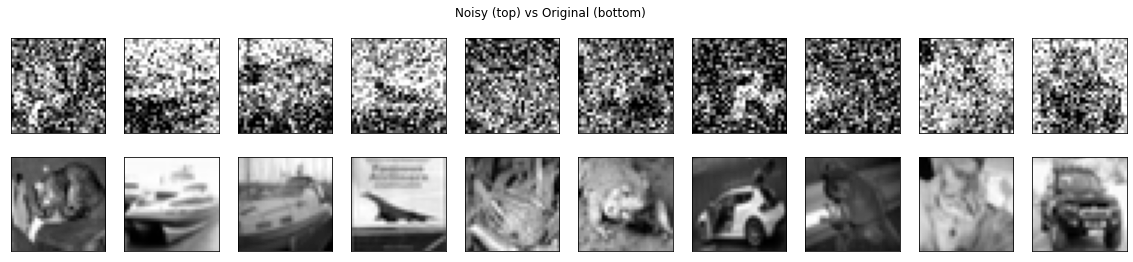

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

Now we define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [ ]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_16 (Dense)            (None, 256)               262400    
                                                                 
 dense_17 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Finally, let us train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0369 - val_loss: 0.0244
Epoch 2/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0222 - val_loss: 0.0195
Epoch 3/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0186 - val_loss: 0.0166
Epoch 4/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 5/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0147 - val_loss: 0.0155
Epoch 6/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0141 - val_loss: 0.0150
Epoch 7/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0144 - val_loss: 0.0133
Epoch 8/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 9/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 10/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 11/

313/313 - 1s - loss: 0.0132 - 821ms/epoch - 3ms/step
Test mse: 0.01319


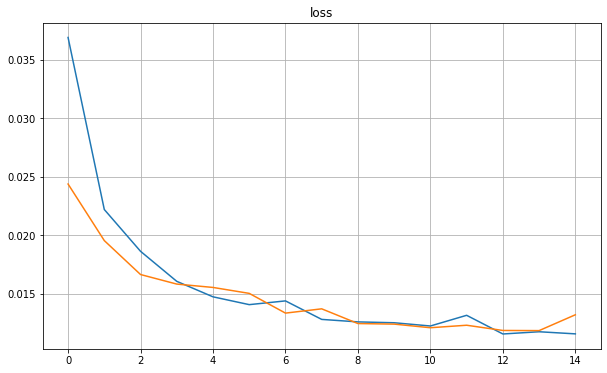

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

Let's also plot some input images and the corresponding denoised outputs.

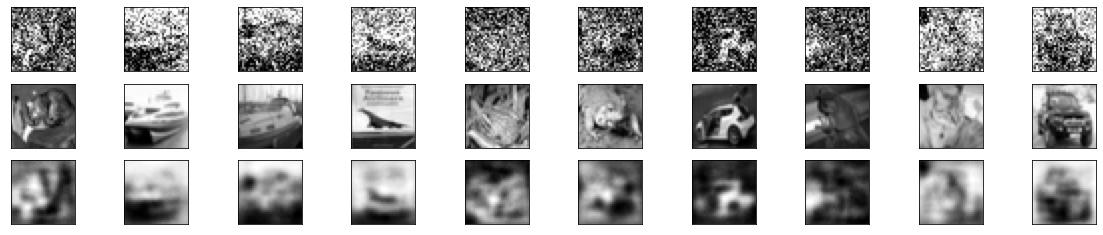

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

We then define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))

encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 94ms/step - loss: 0.2139 - categorical_accuracy: 0.1062 - val_loss: 0.1063 - val_categorical_accuracy: 0.3213
Epoch 2/50
79/79 [==============================] - 7s 91ms/step - loss: 0.0886 - categorical_accuracy: 0.3822 - val_loss: 0.0786 - val_categorical_accuracy: 0.4186
Epoch 3/50
79/79 [==============================] - 7s 92ms/step - loss: 0.0729 - categorical_accuracy: 0.4506 - val_loss: 0.0691 - val_categorical_accuracy: 0.4643
Epoch 4/50
79/79 [==============================] - 7s 92ms/step - loss: 0.0669 - categorical_accuracy: 0.4653 - val_loss: 0.0639 - val_categorical_accuracy: 0.4960
Epoch 5/50
79/79 [==============================] - 7s 92ms/step - loss: 0.0608 - categorical_accuracy: 0.5168 - val_loss: 0.0588 - val_categorical_accuracy: 0.5257
Epoch 6/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0563 - categorical_accuracy: 0.5401 - val_loss: 0.0552 - val_categorical_accuracy: 0.5500
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0193 - categorical_accuracy: 0.8871 - 494ms/epoch - 12ms/step
categorical_accuracy: 88.71%


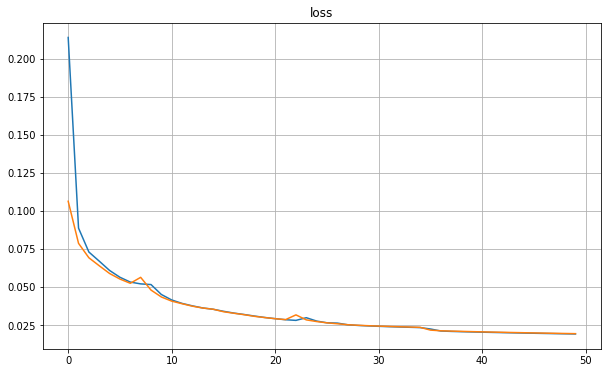

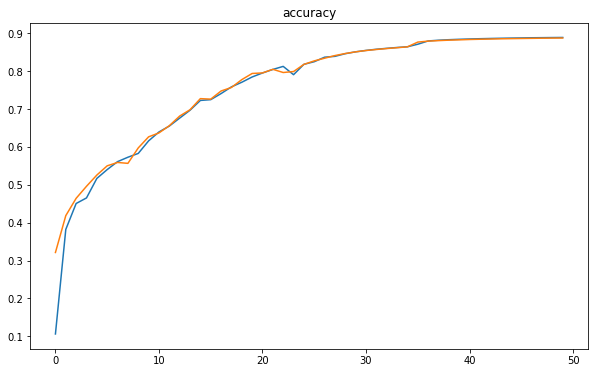

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
people just <oov> <oov> that are <oov> in all of that film but that <oov> the <oov> is <oov> up very <oov> film in just about <oov> <oov> <oov> <oov> as at other <oov> br <oov> out it <oov> is <oov> <oov> of the film are <oov> <oov> and <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is way really <oov> film that <oov> <oov> <oov> i really <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


## Exercise 5.7: Non-Linear Autoencoder for sequences
To conclude, let's replicate the code of the above exercise, but instead of using a simpleRNN with linear activation we now use non-linear activation functions and an LSTM layer.

Note: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))

encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm (LSTM)                 (None, 90, 50)            30200     
                                                                 
 time_distributed_1 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 15s 158ms/step - loss: 0.0433 - categorical_accuracy: 0.4537 - val_loss: 0.0372 - val_categorical_accuracy: 0.4667
Epoch 2/50
79/79 [==============================] - 12s 151ms/step - loss: 0.0358 - categorical_accuracy: 0.4762 - val_loss: 0.0349 - val_categorical_accuracy: 0.4678
Epoch 3/50
79/79 [==============================] - 12s 147ms/step - loss: 0.0329 - categorical_accuracy: 0.4905 - val_loss: 0.0313 - val_categorical_accuracy: 0.4918
Epoch 4/50
79/79 [==============================] - 11s 145ms/step - loss: 0.0286 - categorical_accuracy: 0.4992 - val_loss: 0.0262 - val_categorical_accuracy: 0.4937
Epoch 5/50
79/79 [==============================] - 12s 150ms/step - loss: 0.0233 - categorical_accuracy: 0.5771 - val_loss: 0.0211 - val_categorical_accuracy: 0.6556
Epoch 6/50
79/79 [==============================] - 12s 150ms/step - loss: 0.0183 - categorical_accuracy: 0.7233 - val_loss: 0.0161 - val_categorical_accuracy: 0.763

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 2.3337e-05 - categorical_accuracy: 1.0000 - 755ms/epoch - 19ms/step
categorical_accuracy: 100.00%


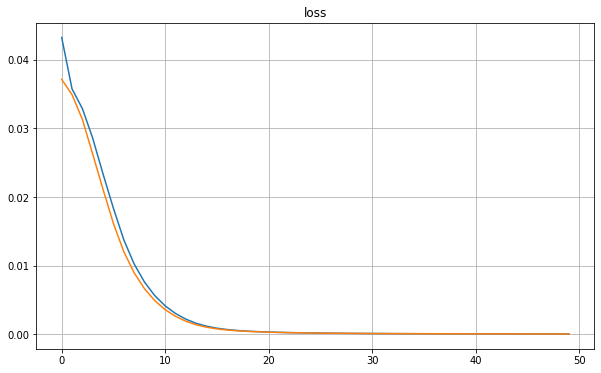

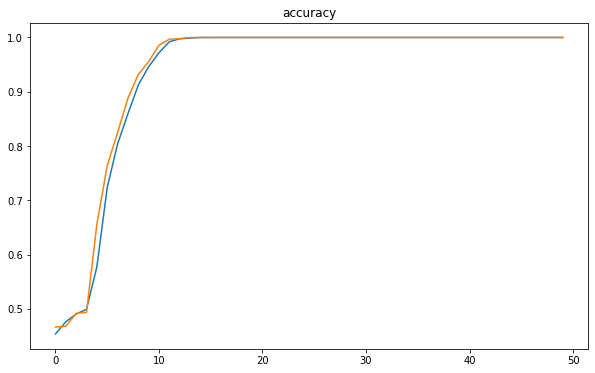

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


As we would expect, the LSTM model performed better than the simple RNN, achieving an accuracy score of 100% on test set!\
Specifically, we used tanh as activation function on the LSTM layer and then softmax on the output layer.\
We chose to use softmax on the output layer given the one-hot nature of the words.\
In fact at each time step t the RNN takes in input a one-hot encoded word and spits in output a vector, which we wish to be possibly very close to the input one.\
It therefore makes sense to use the softmax as activation function on the output layer, since this outputs a vector whose entries are in $(0,1)$ and that can also be interpreted as probability densities (notice that the entries of the input vector are in $\{0, 1\}$ and specifically they are all $0$'s but one of them, which is equal to $1$).